In [1]:
import os.path
import cv2
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [2]:
######## DEFINE FUNCTIONS ########
#sorteerib kastid nende x koordinaadi väärtuse põhjal
#st. et eeldame et tehe on kirjutatud ühes reas
def order_boxes(boxes):
    boxes.sort(key=lambda x:x[0])

def get_areas(boxes):
    areas = []
    for box in boxes:
        areas.append(box[2]*box[3])
    return areas

#lõikab bounding boxide põhjal välja pildist huvipakkuvad pildid
def get_crops(image, boxes, draw=False):
    crops = []
    for box in boxes:
        x,y,w,h = box
        crops.append(image[y:y+h,x:x+w])
    if draw:
        for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            #plt.axis('off')
            plt.imshow(crop, cmap="gray")
    return crops

#muudab pildid listis ruudukujuliseks, lisades puhvrit ümber
def make_square(image_list, square_size=None):
    ruudud = []
    for image in image_list:
        h, w = image.shape
        og_square_edge = max(h,w)
        if h > w:
            pool = (h-w)//2
            #vasakule liidetav pilt, laiusega pool, kõrgusega h, värv 255
            vasakule = np.full((h,pool), 255)
            #paremale liidetav pilt, laiusega h-w-pool, kõrgusega h, värv 255
            paremale = np.full((h,h-w-pool), 255)
            ruudud.append(np.concatenate((vasakule,image,paremale), axis=1))
        else:
            pool = (w-h)//2
            #ules liidetav pilt, laiusega w, kõrgusega pool, värv 255
            ules = np.full((pool, w), 255)
            #alla liidetav pilt, laiusega w, kõrgusega w-h-pool, värv 255
            alla = np.full((w-h-pool, w), 255)
            ruudud.append(np.concatenate((ules,image,alla), axis=0))
      
    #vajadusel muudab ruutude suurust
    if square_size != None:
        lopp_ruudud = []
        for image in ruudud:
            lopp_ruudud.append(cv2.resize(np.array(image, dtype='uint8'), (square_size, square_size), interpolation=cv2.INTER_AREA))
        ruudud = lopp_ruudud
    return ruudud

def draw_crops(crops, draw_axis='on'):
    for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            plt.axis(draw_axis)
            plt.imshow(crop, cmap="gray")
            # plt.imshow(crop)

In [3]:
######## LOAD MODEL AND LABELS ########
loaded_model = keras.models.load_model('./math_symbol_classifier_model_v5')
labels_df = pd.read_csv('labels_df_5.csv', sep=';')
# loaded_model = keras.models.load_model('./math_symbol_classifier_model_v4')
# labels_df = pd.read_csv('labels_df_4.csv', sep=';')
labels_df.drop(labels_df.columns[0], axis=1, inplace=True)
true_labels = np.array(labels_df['true_label'])

In [4]:
filename = 'test_images/subtraction.jpg'

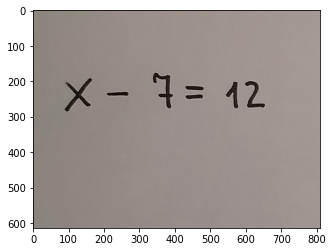

In [5]:
img = cv2.imread(filename)
plt.imshow(img)

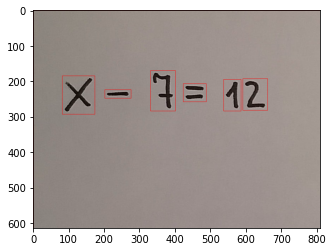

In [8]:
img = cv2.imread(filename)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#blurimine vajalik et eemaldada müra
blur_img = cv2.GaussianBlur(img_gray,(5,5),0)
#thresholdimisega teeme hallist taustast valge ja tekstist musta
ret, thresh = cv2.threshold(blur_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# paksendan jooni kõvasti, et lähedalolevad sümbolid (nt võrdusmärgid) muutuksid üheks
kernel = np.ones((13,13),np.uint8)
thresh_dilate = cv2.erode(thresh, kernel, iterations=1)

contours,hierarchy = cv2.findContours(thresh_dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# contours,hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
boxed_img = img.copy()
joined_boxes = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    # kui kast ei ole terve pildi suurune siis lisame jälgitavasse
    if w < img_gray.shape[1] and h < img_gray.shape[0]:
        joined_boxes.append([x,y,w,h])
    boxed_img = cv2.rectangle(boxed_img,(x,y),(x+w,y+h),(255,0,0),1)

imgbytes = cv2.imencode(".png", boxed_img)[1].tobytes()
plt.imshow(boxed_img)

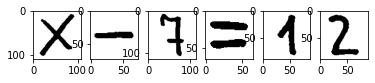

In [9]:
order_boxes(joined_boxes)
crops = get_crops(thresh, joined_boxes, True)

crops = make_square(crops)
tiny_crops = make_square(crops, 45)
draw_crops(crops)


In [ ]:
kernel = np.ones((2,2),np.uint8)
reshaped_crops = np.array([np.reshape(crop,(45,45)) for crop in tiny_crops])
dilated_crops = np.array([cv2.dilate(crop, kernel, iterations=2) for crop in reshaped_crops])

predictions = loaded_model.predict(dilated_crops)
predictions = [np.array(prediction).argmax() for prediction in predictions]